# LAMPADA Hg

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from giopy import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'prisma.csv'
fr = pd.read_csv(FILE)
fr = fr.sort_values('RIFLESSA deg')

In [2]:
# START,,RIFLESSA deg,RIFLESSA prim,GIALLO deg,GIALLO prim,VERDE deg,VERDE prim,BLU deg,BLU prim,VIOLA deg,VIOLA prim

ang_incidente = np.array(fr['RIFLESSA deg'] + 0.01*fr['RIFLESSA prim']/6 - 90)* 0.5 # * np.pi/180
giallo = np.array(90 - fr['GIALLO deg'] + 0.01*fr['GIALLO prim']/6) # * np.pi/180
verde = np.array(90 - fr['VERDE deg'] + 0.01*fr['VERDE prim']/6) # * np.pi/180
blu = np.array(90 - fr['BLU deg'] + 0.01*fr['BLU prim']/6) # * np.pi/180
viola = np.array(90 - fr['VIOLA deg'] + 0.01*fr['VIOLA prim']/6) # * np.pi/180

sigmaY = 0.5 * np.ones_like(giallo) # * np.pi/180
sigmaX = 0.5 * np.ones_like(ang_incidente) # * np.pi/180

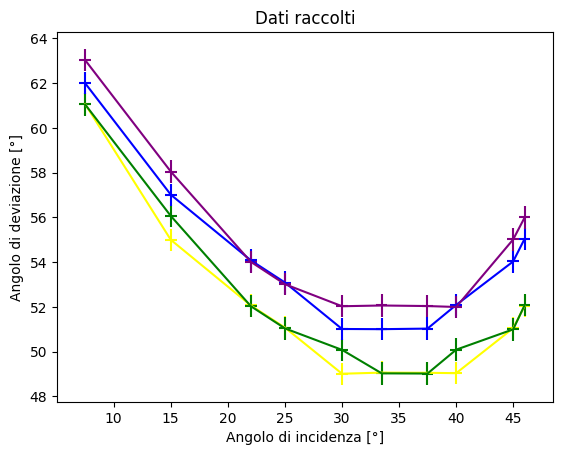

In [3]:
plt.title('Dati raccolti')
plt.errorbar(ang_incidente,giallo,yerr=sigmaY,xerr=sigmaX,color='yellow')
plt.errorbar(ang_incidente,verde,yerr=sigmaY,xerr=sigmaX,color='green')
plt.errorbar(ang_incidente,blu,yerr=sigmaY,xerr=sigmaX,color='blue')
plt.errorbar(ang_incidente,viola,yerr=sigmaY,xerr=sigmaX,color='purple')
plt.xlabel('Angolo di incidenza [°]')
plt.ylabel('Angolo di deviazione [°]')

plt.show()


### ANGOLO MINIMA DEVIAZIONE (FIT PARABOLICO)

Ricaviamo il valore dell'angolo di minima deviazione interpolando con una parabola gli angoli di deviazione



In [4]:
def parabola(x, a, b, θ):
    return a*(x - θ)**2 + b

fit_giallo = Interpolazione(ang_incidente, giallo,sigmaY,sigmaX, parabola, [0.1, 50, 35],names=['a','b','θ'])
fit_verde = Interpolazione(ang_incidente, verde,sigmaY,sigmaX, parabola, [0.1, 50, 35],names=['a','b','θ'])
fit_blu = Interpolazione(ang_incidente, blu,sigmaY,sigmaX, parabola, [0.1, 50, 35],names=['a','b','θ'])
fit_viola = Interpolazione(ang_incidente, viola,sigmaY,sigmaX, parabola, [0.1, 50, 35],names=['a','b','θ'])

fit = np.array([fit_giallo,fit_verde,fit_blu,fit_viola])

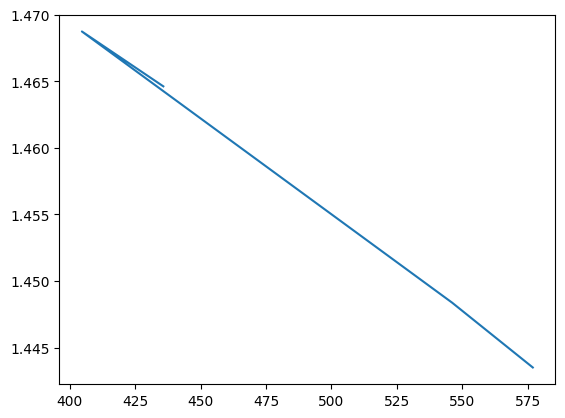

In [5]:
δm = np.array([f.values['θ'] for f in fit]) # indici di rifrazione
sigmaδm = np.array([f.errors['θ'] for f in fit])

n = np.sin((δm + 60)/2 * np.pi/180) / np.sin(30*np.pi/180)

λ_Hg = np.array([435.8, 404.7,546.1, 576.9]) # nm

plt.plot(λ_Hg,n)